# Task 4: Loan Default Risk with Business Cost Optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00
Please upload 'application_train.csv'


Saving application_train.csv to application_train.csv
Data Loaded: (307511, 122)
Classification Report:

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.48      0.02      0.05      4965

    accuracy                           0.92     61503
   macro avg       0.70      0.51      0.50     61503
weighted avg       0.89      0.92      0.88     61503

ROC AUC Score: 0.7569113868892356


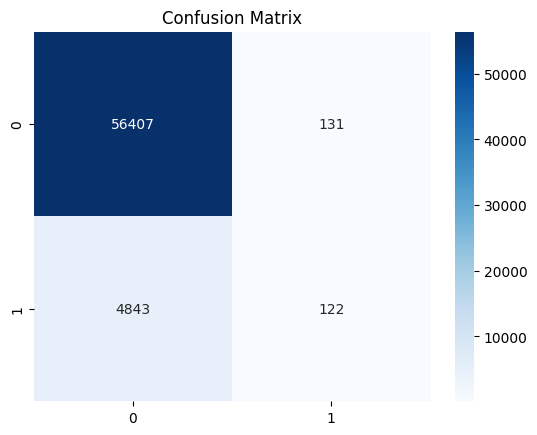

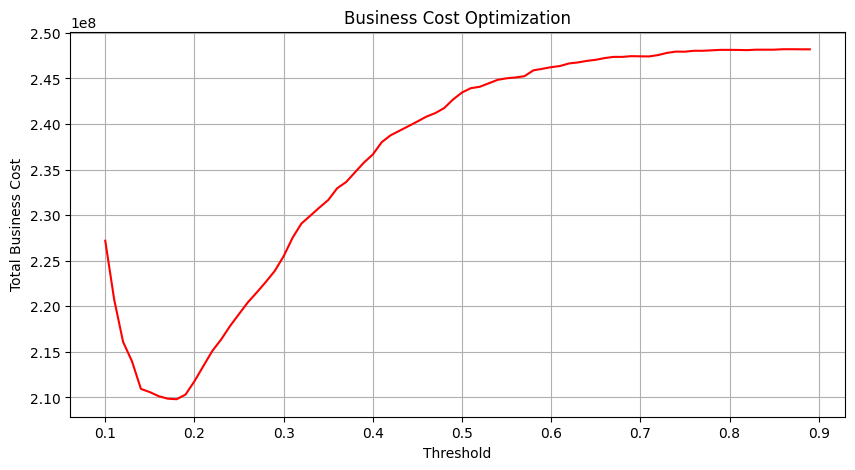

Optimal Threshold: 0.18
Minimum Total Business Cost: $209,810,000


In [5]:
# 1. Install CatBoost
!pip install -q catboost

# 2. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from catboost import CatBoostClassifier
from google.colab import files

# 3. Upload CSV
print("Please upload 'application_train.csv'")
uploaded = files.upload()

# 4. Load Data
df = pd.read_csv("application_train.csv")
print("Data Loaded:", df.shape)

# 5. Basic Preprocessing
df = df.dropna(thresh=0.6 * len(df), axis=1)
df.fillna(df.median(numeric_only=True), inplace=True)

# Encode Categorical Columns
le = LabelEncoder()
for col in df.select_dtypes(include="object").columns:
    df[col] = le.fit_transform(df[col].astype(str))

# 6. Features and Target
X = df.drop(columns=["TARGET", "SK_ID_CURR"])
y = df["TARGET"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 7. Train CatBoost
model = CatBoostClassifier(verbose=0, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# 8. Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
conf = confusion_matrix(y_test, y_pred)
sns.heatmap(conf, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# 9. Business Cost Optimization
cost_fn = 50000  # False Negative = Missed defaulter
cost_fp = 10000  # False Positive = Rejected safe customer

thresholds = np.arange(0.1, 0.9, 0.01)
total_costs = []
for t in thresholds:
    preds = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    cost = fp * cost_fp + fn * cost_fn
    total_costs.append(cost)

# Cost vs Threshold Plot
plt.figure(figsize=(10, 5))
plt.plot(thresholds, total_costs, color='red')
plt.xlabel("Threshold")
plt.ylabel("Total Business Cost")
plt.title("Business Cost Optimization")
plt.grid(True)
plt.show()

# Print Optimal Threshold
min_cost = np.min(total_costs)
best_thresh = thresholds[np.argmin(total_costs)]
print(f"Optimal Threshold: {best_thresh:.2f}")
print(f"Minimum Total Business Cost: ${min_cost:,.0f}")
